# Task IV - Reduce the Number of Device Statistics to Estimate the Service Metric

## 1. Construct a training set and a test set from the trace as in Task III.

## 2. Optimal Method
- Compute a linear regression model for each of these subsets of the training set
- compute NMAE of each model
- histogram of NMAE
- show the features with the smallest error
- box plot of nmae for all models with 1, 2, ..., 12 features

the smallest NMAE (0.10332224) is the model with features:
['runq-sz', '%%memused', 'cswch/s']


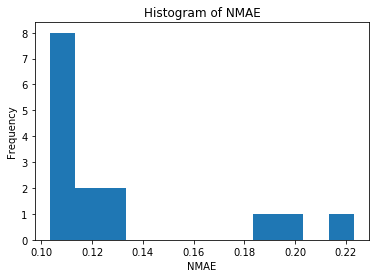

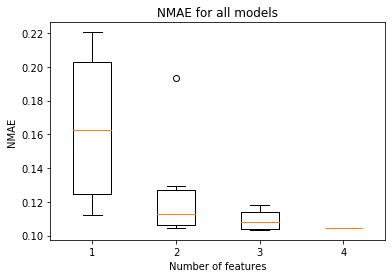

In [7]:
import itertools
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import numpy as np

def subs(l):
    res = []
    for i in range(1, len(l) + 1):
        for combo in itertools.combinations(l, i):
            res.append(list(combo))
    return res

def get_nmae(y_predict, y_test):
    m = len(y_test.index)
    y_mean = y_test['DispFrames'].mean()
    sum_abs_y_mean_predict = 0.0
    i = 0
    for _, row in y_test.iterrows():
        sum_abs_y_mean_predict += abs(row['DispFrames'] - y_predict[i][0])
        i += 1
    
    nmae = (sum_abs_y_mean_predict / m) / y_mean
    return np.round(nmae, decimals=8)

X = pd.read_csv('data/X.csv')
Y = pd.read_csv('data/Y.csv')
Y['TimeStamp'] = Y.TimeStamp.astype(int)
X.index = pd.to_datetime(
    X['TimeStamp'], unit='s')
Y.index = pd.to_datetime(
    Y['TimeStamp'], unit='s')

feature_names = ["runq-sz", "%%memused", "proc/s", "cswch/s", "all_%%usr", 
    "ldavg-1", "totsck", "pgfree/s", 
    "plist-sz", "file-nr", "idel/s", "tps"]

# this is for real
# all_subset = subs(feature_names)

# for testing only, so that my computer does not explode
all_subset = subs(["runq-sz", "%%memused", "proc/s", "cswch/s"])

all_nmae = []
nmaes_boxplot_data = []
min_nmaes_each_feature = []
for subset in all_subset:
    x_train, x_test, y_train, y_test = train_test_split(X[subset], 
        Y[["DispFrames"]], train_size=0.7)
    
    # Compute a linear regression model for each of these subsets of the training set
    regression_model = LinearRegression()
    regression_model.fit(x_train, y_train)
    y_predict = regression_model.predict(x_test)
    
    # compute NMAE of each model
    nmae = get_nmae(y_predict, y_test)
    all_nmae.append(nmae)
    
    if len(nmaes_boxplot_data) < len(subset):
        nmaes_boxplot_data.append([nmae])
    else:
        nmaes_boxplot_data[len(subset) - 1].append(nmae)

    # for instruction number 5
    if len(min_nmaes_each_feature) < len(subset):
        min_nmaes_each_feature.append(nmae)
    else:
        if nmae < min_nmaes_each_feature[len(subset) - 1]:
            min_nmaes_each_feature[len(subset) - 1] = nmae

# show the features with the smallest error
min_nmae = min(all_nmae)
print("the smallest NMAE ({}) is the model with features:".format(min_nmae))
print(all_subset[all_nmae.index(min_nmae)])

# histogram of NMAE
binwidth = 0.01
plt.hist(all_nmae, 
    bins=np.arange(min(all_nmae), max(all_nmae) + binwidth, binwidth))
plt.xlabel("NMAE")
plt.ylabel("Frequency")
plt.title("Histogram of NMAE")
plt.show()

# box plot of nmae for all models with 1, 2, ..., 12 features
fig7, ax7 = plt.subplots()
ax7.set_title("NMAE for all models")
ax7.set_xlabel("Number of features")
ax7.set_ylabel("NMAE")
ax7.boxplot(nmaes_boxplot_data)
plt.show()

### Analysis

The method used to find the features with the smallest error is by building a subset of each features, build the linear regression model, then find the smallest NMAE of all the models built. The features with the smallest error are: ...

From the histogram, we can see the the highest number of error (NMAE) is ... with ... data. This means that the models mostly have ... error with various features applied to the model.

The boxplot shows the relation between the number of features and the NMAE. The growth of the function resembles the inverse logarithmic function, with the NMAE seems to saturate when the number of features exceeds 4.

## 3. Method 2 (Heuristic method)
- Rank the features according to the square of the correlation values (sort descending order)
- Build twelve feature sets composed of the top k features, k = 1, ..., 12. The first feature set contains the top feature, the second feature set contains the top two features, etc
- compute the linear regression model on the training set and compute the error
- Produce a plot that shows the error value in function of the set size k

Rank of the features according to the square of the correlation values:
plist-sz
totsck
runq-sz
ldavg-1
cswch/s
file-nr
all_%%usr
%%memused
idel/s
proc/s
pgfree/s
tps


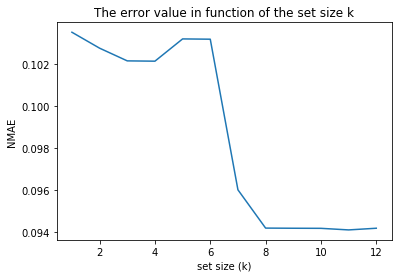

In [10]:
x_train, x_test, y_train, y_test = train_test_split(X, 
        Y[["DispFrames"]], train_size=0.7)

m = len(x_train.index)

correlation_square_map = {}
correlation_map = {}
for feature in feature_names:
    x_mean = x_train[feature].mean()
    y_mean = y_train["DispFrames"].mean()
    x_std = x_train[feature].std()
    y_std = y_train["DispFrames"].std()
    sum_all = 0.0
    
    for idx, xi in x_train.iterrows():
        sum_all += ((xi[feature] - x_mean) * (y_train["DispFrames"][idx])) \
            / (x_std * y_std)
    
    correlation = sum_all / m
    correlation_square_map[feature] = correlation ** 2
    correlation_map[feature] = correlation

# Rank the features according to the square of the correlation values (sort descending order) 
sorted_correlation_sq_tuple = sorted(correlation_square_map.items(), key=lambda kv: kv[1],
    reverse=True)
sorted_feature = [feature[0] for feature in sorted_correlation_sq_tuple]
print("Rank of the features according to the square of the correlation values:")
for feature in sorted_feature:
    print(feature)

all_nmaes = []
for i in range(1, len(sorted_feature) + 1):
    # Build twelve feature sets composed of the top k features
    # compute the linear regression model on the training set and compute the error
    regression_model = LinearRegression()
    regression_model.fit(x_train[sorted_feature[0:i]], y_train)
    y_predict = regression_model.predict(x_test[sorted_feature[0:i]])
    nmae = get_nmae(y_predict, y_test)
    all_nmaes.append(nmae)

# Produce a plot that shows the error value in function of the set size k
plt.plot(range(1, len(all_nmaes) + 1), all_nmaes)
plt.xlabel("set size (k)")
plt.ylabel("NMAE")
plt.title("The error value in function of the set size k")
plt.show()

### Analysis

The correlation values calculated is within the range [-1, +1]. The rank of the correlation values presented is the square of the correlation values, which means all features ranked is positive values. By ranking the square of the correlation values, it is expected to see how each features contribute to the estimated values.

Rank of the features according to the square of the correlation values:
plist-sz
totsck
runq-sz
ldavg-1
cswch/s
file-nr
all_%%usr
%%memused
idel/s
proc/s
pgfree/s
tps

Thsis heuristic method also shows how many features we need to build such a reliable model in a heuristic way. If the number of features included in a model is less then 6, the NMAE is relatively high. If the number of features is more than 6, the NMAE is steeply reduced. We can say that 8 features is the good number of features to build a model, whereas if we give more than 8, it will not significantly improve the model.

## 4 Correlation matrix is a table showing the correlation between variables

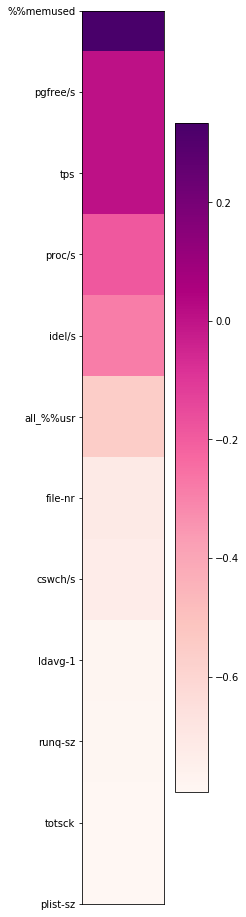

In [11]:
sorted_correlation = sorted(correlation_map.items(), key=lambda kv: kv[1],
    reverse=True)
sorted_feature = [feature[0] for feature in sorted_correlation]
sorted_correlation = [[val[1]] for val in sorted_correlation]
plt.matshow(sorted_correlation, cmap='RdPu')
plt.colorbar()

y_pos = np.arange(len(sorted_correlation))
plt.yticks(y_pos, sorted_feature)

x_pos = [1]
plt.xticks(x_pos, ["DispFrames"])

plt.show()

## 5. Compare the optimal method with the heuristic method

- A single plot with two curves: The vertical axis is NMAE and horizontal axis is the size k of the feature set.
  - The first curve shows the minimum error of the optimal method for feature sets of size k
  - The second curve shows the error of heuristic method for the sets with the top k features

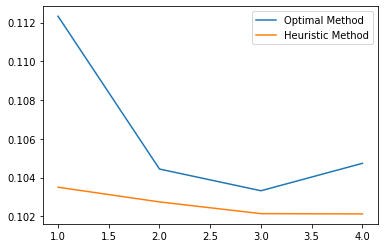

In [12]:
plt.plot(range(1, len(min_nmaes_each_feature) + 1), min_nmaes_each_feature, label='Optimal Method')
plt.plot(range(1, len(min_nmaes_each_feature) + 1), 
    all_nmaes[0:len(min_nmaes_each_feature)], label='Heuristic Method')
plt.legend()
plt.show()